### Get feature importance

#### Feature selection

TO DO: READ ABOUT RECURSIVE FEATURE ELIMINTATION!!!!

Do recursive feature elimination first, then decision tree, get feature importance , set a threshold and choose the top 5 most important features


L1 (L2) regularization

PCA, then random forest classifier, get feature importance 

Autoencoder

#### Clustering

KMEANS
DBSCAN (sklearn)

## To do: clustering fuel only cars
1. T-SNE, read about it, do dimensionality reduction

## Pair wise clustering
1. Hybrid and electric
2. Hybrid and fuel

## Fuzzy logic
Can we calculate car membership?
Read on fuzzy logic 

## Consumer analysis with scraped data 
Predictor for time series sales data
Couple sales data with the co2 scores
Accumulated prediction for co2 impact 


In [1]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from pathlib import Path

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics

import xgboost as xgb


from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
sys.path.append(os.path.abspath(os.path.join('..','./scripts/')))



In [2]:
# Load the dataset into a pandas DataFrame
clean_data = os.path.abspath(os.path.join(os.getcwd(), "..",'data', 'predicted-data'))

fuel_df = pd.read_csv(Path(clean_data,"predicted_co2_rating.csv"))
hybrid_df = pd.read_csv(Path(clean_data,"predicted_co2_rating_hybrid.csv"))
electric_df = pd.read_csv(Path(clean_data,"predicted_co2_rating_electric.csv"))

# drop the 'original_co2r' column from the dataframes
fuel_df.drop('original_co2r', axis=1, inplace=True)

# drop smog_rating from the dataframes
hybrid_df.drop('smog_rating', axis=1, inplace=True)
electric_df.drop('smog_rating', axis=1, inplace=True)

# rename co2_rating to predicted_co2r in hybrid_df and electric_df
hybrid_df.rename(columns={'co2_rating': 'predicted_co2_rating'}, inplace=True)
electric_df.rename(columns={'co2_rating': 'predicted_co2_rating'}, inplace=True)

# rename fuel_type1 to fuel_type in fuel_df, hybrid_df, and electric_df
fuel_df.rename(columns={'fuel_type1': 'fuel_type'}, inplace=True)
hybrid_df.rename(columns={'fuel_type1': 'fuel_type'}, inplace=True)
electric_df.rename(columns={'fuel_type1': 'fuel_type'}, inplace=True)


# merge vehicle_type and id into a single column for fuel_df

def merge_vehicle_id(df):
    df['vehicle_id'] = df['vehicle_type'] + '_' + df['id'].astype(str)

    df.drop(['id'], axis=1, inplace=True)
    return df


fuel_df = merge_vehicle_id(fuel_df)

# set fuel_df to contain only cars from 2012 onwards
fuel_df = fuel_df[fuel_df['model_year'] >= 2012]
hybrid_df = merge_vehicle_id(hybrid_df)
electric_df = merge_vehicle_id(electric_df)



In [ ]:
electric_df['model_year'].unique()

In [3]:
df = pd.concat([fuel_df, hybrid_df, electric_df], axis=0, ignore_index=True)

# convert f['vehicle_type'] to a categorical variable
df['vehicle_type'] = df['vehicle_type'].astype('category')


# move vehicle_id to the first column
cols = df.columns.tolist()

# obtain position of vehicle_id column from cols
vehicle_id_index = cols.index('vehicle_id')

# move vehicle_id to the first column
cols = [cols[vehicle_id_index]] + cols[:vehicle_id_index] + cols[vehicle_id_index+1:]

df = df[cols]

# fill missing values with 0
df.fillna(0, inplace=True)

In [ ]:
import seaborn as sns

# create a correlation matrix
corr = df.corr(numeric_only=True)

# plot the correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
df[df['vehicle_type']=='hybrid']['mapped_fuel_type']

/Users/macpro/anaconda3/envs/ml-project-env-10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.9930731932579081
Selected features: Index(['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)',
       'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)',
       'number_of_gears', 'predicted_co2_rating', 'enginesize_(l)',
       'fuelconsumption_comb(mpg)', 'motor_(kw)', 'range1_(km)',
       'recharge_time(h)', 'range2_(km)', 'fuelconsumption_comb(kwh/100km)',
       'fuelconsumption_city(le/100km)', 'fuelconsumption_hwy(le/100km)',
       'fuelconsumption_comb(le/100km)', 'vehicle_type_electric',
       'vehicle_type_fuel-only', 'vehicle_type_hybrid',
       'mapped_fuel_type_diesel', 'mapped_fuel_type_electricity',
       'mapped_fuel_type_ethanol (E85)', 'mapped_fuel_type_natural gas',
       'mapped_fuel_type_premium gasoline',
       'mapped_fuel_type_regular gasoline'],
      dtype='object')


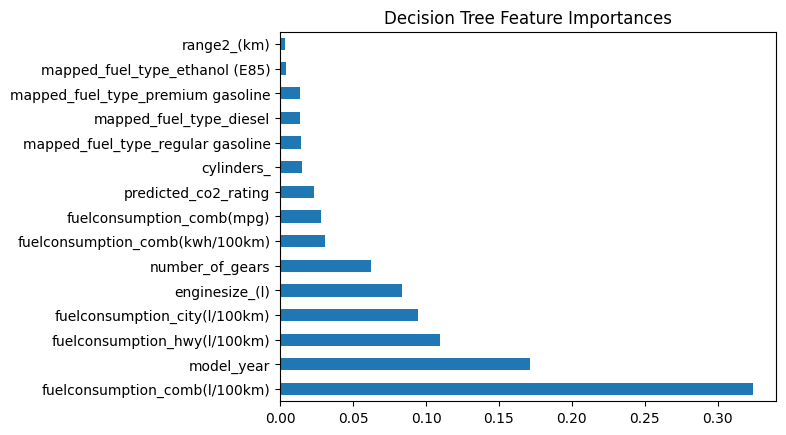

Top features: ['model_year', 'cylinders_', 'fuelconsumption_city(l/100km)', 'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)', 'number_of_gears', 'predicted_co2_rating', 'enginesize_(l)', 'fuelconsumption_comb(mpg)', 'range2_(km)', 'fuelconsumption_comb(kwh/100km)', 'mapped_fuel_type_diesel', 'mapped_fuel_type_ethanol (E85)', 'mapped_fuel_type_premium gasoline', 'mapped_fuel_type_regular gasoline']


In [4]:
# Select the columns with numerical and categorical data
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(exclude=np.number).columns

# One-hot encode the categorical columns
df_cat = pd.get_dummies(df[['vehicle_type','mapped_fuel_type']])
df_num = df[num_cols]

# Combine the numerical and one-hot encoded categorical dataframes
df_processed = pd.concat([df_num, df_cat], axis=1)

# Perform recursive feature elimination to select the most important features
X = df_processed.drop(["co2emissions_(g/km)"], axis=1)
y = df_processed["co2emissions_(g/km)"]


# set up xgboost model for classification and feature selection
dt = DecisionTreeClassifier(random_state=42)
rfecv = RFECV(estimator=dt, cv=10)
rfecv.fit(X, y)

# predict
y_pred = rfecv.predict(X)

# Print the accuracy
print("Accuracy:", metrics.accuracy_score(y, y_pred))

# Print the most important features
print("Selected features:", X.columns[rfecv.support_])

# Fit a decision tree and get feature importances
dt.fit(X, y)
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)

# Plot the feature importances
plt.figure()
plt.title('Decision Tree Feature Importances')
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

# Select the top 5 most important features
threshold = feat_importances.nlargest(15).min()
top_features = feat_importances[feat_importances >= threshold].index.tolist()
print("Top features:", top_features)


In [ ]:


# select the top 5 important features
# select only the top 5 important features
X = X[top_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[top_features])

# create a range of cluster numbers
range_n_clusters = range(2, 11)

# initialize lists to store the scores
silhouette_scores = []
inertia_scores = []

# loop over the range of cluster numbers
for n_clusters in range_n_clusters:
    
    # initialize KMeans with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init=10)
    
    # fit KMeans to the data
    kmeans.fit(X)
    
    # calculate the inertia score (within-cluster sum of squares)
    inertia_scores.append(kmeans.inertia_)
    
    # calculate the silhouette score
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # print the scores
    print("For n_clusters =", n_clusters,
          "The inertia score is :", kmeans.inertia_,
          "The average silhouette score is :", silhouette_avg)

# plot the elbow curve
plt.plot(range_n_clusters, inertia_scores, 'bx-')
plt.xlabel('Number of Clusters')
# set xticks to be the range of cluster numbers
plt.xticks(range_n_clusters)
plt.ylabel('Inertia Score')
plt.title('Elbow Method for Optimal k')
plt.show()

# plot the silhouette scores
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters')
# set xticks to be the range of cluster numbers
plt.xticks(range_n_clusters)
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()


In [ ]:
X.columns

In [5]:
continuous_vars= X.columns

# Select the clustering variable
cluster_var = 'cluster'

# Fit the KMeans clustering algorithm
kmeans = KMeans(n_clusters=3,random_state=0,n_init=10)
kmeans.fit(X[continuous_vars])

# Add the cluster labels to the DataFrame
X[cluster_var] = kmeans.labels_

# # # Create the scatter plot matrix
# sns.pairplot(X, vars=continuous_vars, hue=cluster_var)

# # Show the plot
# plt.show()


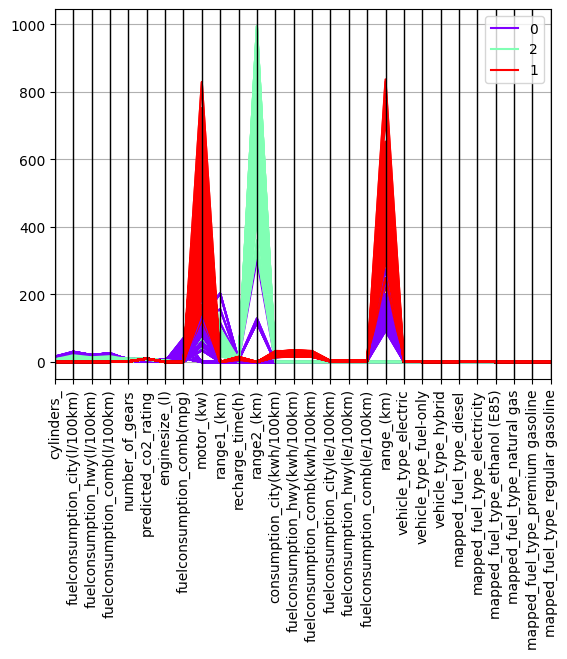

In [11]:
# Create the parallel coordinates plot
from pandas.plotting import parallel_coordinates
data_cont2=X
#data_cont2.drop('model_year', axis=1, inplace=True)
parallel_coordinates(X, cluster_var, colormap='rainbow')

# turn x-axis labels vertically
plt.xticks(rotation=90)
# Show the plot
plt.show()

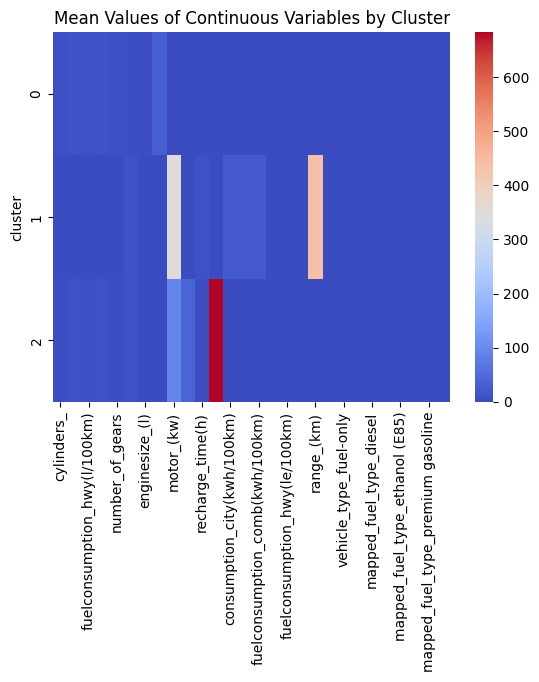

In [9]:
data_cont = X
import seaborn as sns

# drop 'model_year' 
#data_cont.drop('model_year', axis=1, inplace=True)
# calculate the mean of each variable for each cluster
data_mean = data_cont.groupby('cluster').mean()

# create the heatmap
sns.heatmap(data_mean, cmap='coolwarm')

# set the plot title
plt.title('Mean Values of Continuous Variables by Cluster')
plt.show()

In [ ]:

def perform_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters, labels

def find_best_dbscan_params(X, eps_list, min_samples_list):
    silhouette_scores = []
    for eps in eps_list:
        for min_samples in min_samples_list:
            n_clusters, labels = perform_dbscan(X, eps, min_samples)
            if n_clusters > 1:
                silhouette_score = metrics.silhouette_score(X, labels)
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters,
                      "and the average silhouette score is", silhouette_score)
                silhouette_scores.append(silhouette_score)
            else:
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters)
    # print the parameter combination with the highest silhouette score
    max_index = silhouette_scores.index(max(silhouette_scores))
    eps_index = max_index // len(min_samples_list)
    min_samples_index = max_index % len(min_samples_list)
    best_eps = eps_list[eps_index]
    best_min_samples = min_samples_list[min_samples_index]
    print("The best parameter combination is eps =", best_eps,
          "and min_samples =", best_min_samples)
    return best_eps, best_min_samples

def perform_best_dbscan(X, best_eps, best_min_samples):
    n_clusters, labels = perform_dbscan(X, best_eps, best_min_samples)
    if n_clusters > 1:
        silhouette_score = metrics.silhouette_score(X, labels)
        print("Number of clusters in DBSCAN:", n_clusters)
        print("The average silhouette score is :", silhouette_score)
    else:
        print("DBSCAN only found one cluster")


eps_list = [0.5, 1, 2, 4, 8, 16]
min_samples_list = [5, 10, 20, 50, 100, 200]

best_eps, best_min_samples = find_best_dbscan_params(X_scaled, eps_list, min_samples_list)
perform_best_dbscan(X_scaled, best_eps, best_min_samples)

In [ ]:
def perform_dbscan(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    return n_clusters, labels

def find_best_dbscan_params(X, eps_list, min_samples_list):
    max_silhouette_score = -1
    best_eps, best_min_samples = None, None
    for eps in eps_list:
        for min_samples in min_samples_list:
            n_clusters, labels = perform_dbscan(X, eps, min_samples)
            if n_clusters == 2:
                silhouette_score = metrics.silhouette_score(X, labels)
                if silhouette_score > max_silhouette_score:
                    max_silhouette_score = silhouette_score
                    best_eps, best_min_samples = eps, min_samples
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters,
                      "and the average silhouette score is", silhouette_score)
            else:
                print("For eps =", eps, "and min_samples =", min_samples,
                      "the number of clusters is", n_clusters)
    # print the best hyperparameters
    print("The best hyperparameters for 2 clusters are: eps =", best_eps,
          "and min_samples =", best_min_samples)
    return best_eps, best_min_samples

def perform_best_dbscan(X, best_eps, best_min_samples):
    n_clusters, labels = perform_dbscan(X, best_eps, best_min_samples)
    if n_clusters == 2:
        silhouette_score = metrics.silhouette_score(X, labels)
        print("Number of clusters in DBSCAN:", n_clusters)
        print("The average silhouette score is:", silhouette_score)
    else:
        print("DBSCAN did not find 2 clusters")

# example usage

eps_list = [0.5, 4, 8, 16]
min_samples_list = [5, 10, 20, 50, 100, 200]

best_eps, best_min_samples = find_best_dbscan_params(X_scaled, eps_list, min_samples_list)
perform_best_dbscan(X_scaled, best_eps, best_min_samples)

In [ ]:
n_clusters, labels = perform_dbscan(X_scaled, 4, 5)

In [ ]:
original_data = scaler.inverse_transform(X_scaled)

pd.DataFrame(original_data, columns = top_features)

In [ ]:
df['cluster'] = labels

In [ ]:
df['cluster'].value_counts()

In [ ]:
df[df['cluster']==1]['predicted_co2_rating'].value_counts()

In [ ]:
df[df['cluster']==0]['predicted_co2_rating'].value_counts()

In [ ]:
X_tsne

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot the data using t-SNE
plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.show()

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot the data using t-SNE
plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.show()